## EECS 531 - A2 - E4
### Tristan Maidment - tdm47

#### Goal
The goal for this exercise is to:

`A.` Understand PCA. While the conceptual idea behind PCA is not complex, extrapolation of the idea to a high dimension data set such as the MNIST digits is initially quite difficult.

`B.` Try a random novel application of PCA.  The ability to reconstruct representations of digits with only the first 20-30 principle components reminded me of quantization in JPEG compression.  For that reason I see if I can use PCA to compress an image.

#### Implementation

In [1]:
%matplotlib inline
import numpy as np
import math
import cv2
from matplotlib import pyplot as plt
from matplotlib.mlab import PCA
import mnist
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

The MNIST data set unfortunately requires a decent amount of work to interact with.  Fortunately, people seem to understand that, and Python has a very nice package to import it.

In [2]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

To test the functionality of the package, I print the first image, and the corresponding label.  As we can see, we have something that somewhat resembles a 5?

5


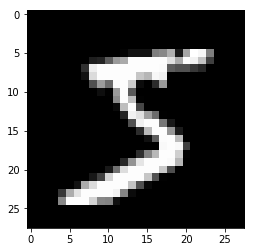

In [3]:
plt.imshow(train_images[0], cmap='gray')
print(train_labels[0])
plt.show()

In order to use the `sklearn` PCA decomposition, we need to vectorize the dataset.  Each `28*28` image needs to be turned into a `1x728` vector.

In [4]:
n, h, w = train_images.shape
X = np.reshape(train_images,(n, h*w))
print("Number of images:", X.shape[0], "| Vector Size:", X.shape[1])

Number of images: 60000 | Vector Size: 784


The next step is to *fit* the data, which is used to initialize the data in the PCA module, then *transform* the data.  This transformation is where the data set is computed into its principle components. 

In [5]:
pca = PCA()
X_transformed = pca.fit_transform(X)

One interesting aspect of PCA is that there are *exactly* 784 dimensions required to get a full representation of the data.  This is because there is no way to represent the original input space with less dimensions.

For example, image a set of points on two axis, `X` and `Y`.  A majority of the variance may be able to be captured on the first principle component.  If reconstruction of the original space was attempted with just the first dimension (principle component), the exact position of each point cannot be determined.  In order to achieve an exact reconstruction of the space, both the first and second principle components are required.

In [6]:
print(X.shape)
print(X_transformed.shape)

(60000, 784)
(60000, 784)


The first two principle components should capture the majority of variance in the data set.  To visualize this, we can plot the position of each image in the MNIST data set with respect to the first two components.  To see the clustering of digits, the data has been colored.

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


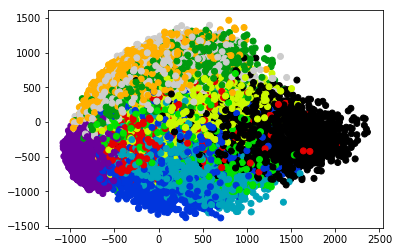

In [7]:
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=train_labels, cmap=plt.cm.get_cmap('spectral', 10))
plt.show()

A lot of the data has been captured well via the first two principle components.  For instance, the pruple and black regions seem fairly well defined.  Unfortunately, there is a large amount of "noise" in the center of the mass.  Due to the high dimensionality of the dataset, it may be benefitial to visualize the data set in three dimensions, with respect to the first three principle components.  

We can see the purple, blue, and cyan regions have fairly well definition, while the black region has more variation than first believed.

Unfortunately, it difficult to represent more than 3 dimensions.

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


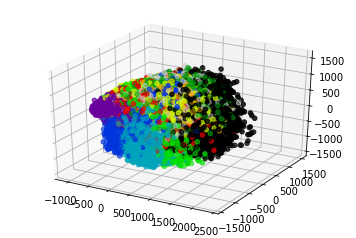

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=train_labels, cmap=plt.cm.get_cmap('spectral', 10))
plt.show()

This is a simple method to convert the vectorized data back into a plottable image.

In [9]:
def plot_vector(vec):
    size = 28
    img = vec.reshape(size, size)
    return img

With this function, we can visualize the first principle component.  This image captures the largest variance in written digits. This first principle component is represents is the X axis in the 2D graph shown earlier. Upon initial examination it appears to differntiate between numbers 0 and 1. The low intensity pixels, or black pixels correspond to digits on the left side of the graph.  The clustered purple region in the graph just so happens to represent the number 1.

The high intensity pixels represent that right of the graph.  Numbers that happen to cover a lot of those pixels, such as 8, 6 and most specifically 0, are weighted toward that side.  The black region is in fact the number 0.  The middle regions are populated with numbers that cannot be specified well by the first principle component.

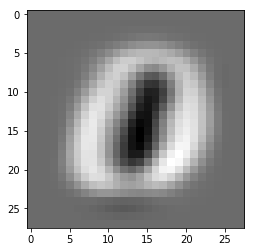

In [10]:
plt.imshow(plot_vector(pca.components_[0]), cmap='gray')
plt.show()

However, the second principle component does a majority of that specification. Shown below, the image is slightly less obvious upon first glance.  However, it the black pixels represent pixels often occupied by such as 3, and 8, which are blue and cyan, respectively.  The high intensity pixels represent numbers such as 9 and 7, among others.

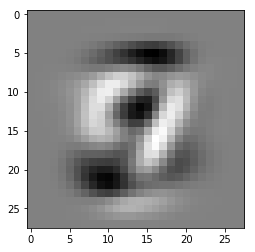

In [11]:
plt.imshow(plot_vector(pca.components_[1]), cmap='gray')
plt.show()

The reconstruction process requires to know the `mean` of the principle components.  Since each dimension (pixel) is effectively *shifted*, the mean represents the amount of *shift* per pixel.

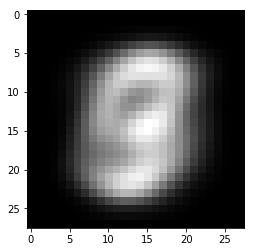

In [12]:
plt.imshow(plot_vector(pca.mean_), cmap='gray')
plt.show()

Using this, we can reconstruct the entire MNIST data set in terms of principle components.  In order to do this, we must multiply the each principle component by the the corresponding intensities of each data digit in the data set.  This is extremely similar to `idct2` defined in exercise 2.  For that reason, it can be efficiently done using the dot product!  

In order two only get the first `k` principle components when reconstructing, we need to limit the data.  Knowing that the dot product multiples each row by column, we can limit the rows and column of each.

In [13]:
def reconstruct(mean, transform, components, k):
    return mean + (transform[:,:k] @ components[:k,:])

reconstruction = reconstruct(pca.mean_, X_transformed, pca.components_, 25)

To illustrate the reconstruction of individual images using principle parts, we will be using the same the digit with index `255`.  First we will reconstruct the image using the first 25 principle components.  We can see that the number is fairly well approximated. but the edges are not well defined.  In addition, a fair amount of noise can be seen.

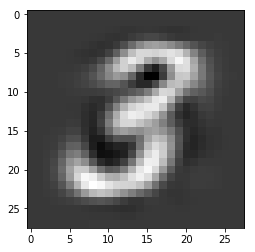

In [14]:
plt.imshow(plot_vector(reconstruction[255,:]), cmap='gray')
plt.show()

Using the first 50 principle components, we get a much better representation.  While the 3 looks approximately the same the amount of noise in the background, indicated by the gray pixels.  As we add more principle components, this background should be black.

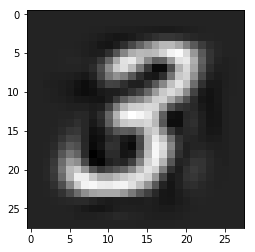

In [15]:
reconstruction = reconstruct(pca.mean_, X_transformed, pca.components_, 50)
plt.imshow(plot_vector(reconstruction[255,:]), cmap='gray')
plt.show()

With 100 principle components, the amount of noise on the background has been significantly decreased as expected.  Furthermore, the edges of the digit are very well defined now.

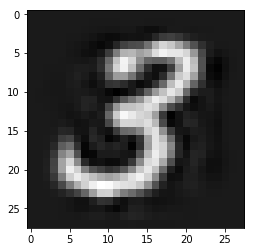

In [16]:
reconstruction = reconstruct(pca.mean_, X_transformed, pca.components_, 100)
plt.imshow(plot_vector(reconstruction[255,:]), cmap='gray')
plt.show()

#### Compression
Throughout the process of reconstruction using the principle components, I found many parallels to inverse discrete transform.  Due to the fact that an image can be approximated via an incomplete set of principle components, and the corresponding intensities of each component, using PCA for image compression may provide interesting results. We will use the same image used for JPEG compression in exercise 2.

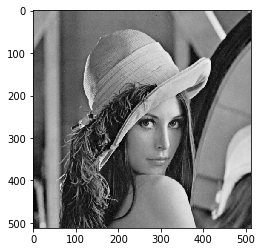

In [17]:
img = cv2.imread('./Lena.png', cv2.COLOR_BGR2GRAY)
gray = np.float32(img)/255.0
plt.imshow(gray, cmap = 'gray')
plt.show()

With the MNIST data set image, the principle components defined the variation between each digit.  For image compression the principle components will define the variation between intensities of each column.  The compression provided by PCA should be fairly accurate due to the fact that the columns of an image are highly correlated with neighboring columns, due to images containing edges and lines.

In [18]:
gray_transformed = pca.fit_transform(gray)

The resulting components depict the amount of variance.  Due to how the PCA analysis is done, the principle components are shown by rows.  The top row is the first principle component, the one below is the second, etc.

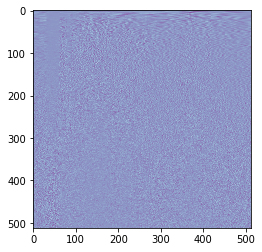

In [19]:
plt.imshow(pca.components_, cmap='BuPu')
plt.show()

Using the same methods as before, we can reconstruct the image using a variable amount of principle components.  To see how PCA fairs in terms of image compression, we will test it with 25 principle components.

In [20]:
reconstruction = reconstruct(pca.mean_, gray_transformed, pca.components_, 25)

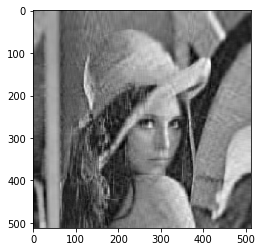

In [21]:
plt.imshow(reconstruction, cmap='gray')
plt.show()

The quality using 25 principle components is not very good.  However, an increase in principle components would increase the quality.  Using 50 principle components, this reconstruction uses about 10% of the data in comparison to the original image.

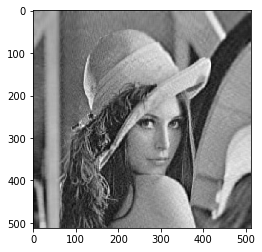

In [22]:
reconstruction = reconstruct(pca.mean_, gray_transformed, pca.components_, 50)
plt.imshow(reconstruction, cmap='gray')
plt.show()

With 100 principle we get a reconstruction of the original image that does not have percievable quality loss.

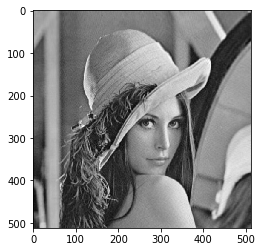

In [23]:
reconstruction = reconstruct(pca.mean_, gray_transformed, pca.components_, 100)
plt.imshow(reconstruction, cmap='gray')
plt.show()

#### Conclusion
In conclusion, PCA is a powerful tool in optimizing data representation.  The ability to be able to break down the visualization of digits more efficiently can be extrapolated to many other problems.  The technique appears to be very useful due to its effiency, and reconstruction using the principle components is powerful due to its ability to reduce dimensionality.  For that reason it should be beneficitial for classifier problems, especially those related to neural networks, which benefit from large variance in higher layers.